In [2]:
import os
import sys
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pydicom as di
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
from PIL import Image

2023-02-18 19:48:49.392691: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [3]:
train_dir = "../dataset/train_images/"
test_dir = "../dataset/test_images/"

In [4]:
#Function to get numpy array of the given image_id
def imageid_to_numpy(patient_id, image_id):
    path_to_images = f"{train_dir}{patient_id}/{image_id}.dcm"
    dcm_image = di.dcmread(path_to_images)
    np_array = dcm_image.pixel_array
    return np_array

#Function to copy dcm image as png
def copy_dcm_as_png(path_to_dcm, png_save_path):
    im = Image.fromarray(imageid_to_numpy(path_to_dcm))
    im.save(png_save_path)


### Work in progress
# takes df with info of a single patient and concats the corresponding images into one
def image_concat(patient_df):
    image_array = []
    for image_id in patient_df[patient_df['laterality'] == 'L']['image_id']:
        image_array.append(imageid_to_numpy(patient_df['patient_id'][0], image_id))
    
    row1 = np.concatenate(6(image_array[0], image_array[1]), axis = 1) # concat L images

    for image_id in patient_df[patient_df['laterality'] == 'R']['image_id']:
        image_array.append(imageid_to_numpy(patient_df['patient_id'][0], image_id))

    row2 = np.concatenate((image_array[0], image_array[1]), axis = 1) # concat R images

    final_image = np.concatenate((row1, row2), axis=0) # concat L and R images

    # im = Image.fromarray(final_image)
    # im = im.convert('RGB')
    # im.save('./concat_images/{}.png'.format(patient_id), compress_level = 1)

    cv2.imwrite('./concat_images/{}.png'.format(patient_df['patient_id'][0]), final_image)

    #####
    # processing is very slow for some reason
    #####

<>:21: SyntaxWarning: 'int' object is not callable; perhaps you missed a comma?
<>:21: SyntaxWarning: 'int' object is not callable; perhaps you missed a comma?
/tmp/ipykernel_7936/3954163558.py:21: SyntaxWarning: 'int' object is not callable; perhaps you missed a comma?
  row1 = np.concatenate(6(image_array[0], image_array[1]), axis = 1) # concat L images


In [5]:
# Loading the CSV file and cleaning the data
train_csv = pd.read_csv("../dataset/train.csv")
train_csv.head(10)

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True
5,2,10011,270344397,L,MLO,55.0,0,0,0,0.0,0,NaN,21,True
6,2,10011,541722628,R,CC,55.0,0,0,0,NaN,0,NaN,21,False
7,2,10011,1031443799,R,MLO,55.0,0,0,0,NaN,0,NaN,21,False
8,2,10025,562340703,L,CC,75.0,0,0,0,NaN,0,NaN,29,False
9,2,10025,1365269360,L,MLO,75.0,0,0,0,NaN,0,NaN,29,False


In [6]:
# Creating colums for n_images -> Number of images for each patient.
#                     resolution -> Dimensions of the corresponding image.
train_csv['n_images'] = [0 for _ in range(train_csv.shape[0])]
train_csv['resolution'] = [None for _ in range(train_csv.shape[0])]
train_csv['readable'] = [None for _ in range(train_csv.shape[0])]
train_csv.head(10)

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,n_images,resolution,readable
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False,0,None,None
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False,0,None,None
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False,0,None,None
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False,0,None,None
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True,0,None,None
5,2,10011,270344397,L,MLO,55.0,0,0,0,0.0,0,NaN,21,True,0,None,None
6,2,10011,541722628,R,CC,55.0,0,0,0,NaN,0,NaN,21,False,0,None,None
7,2,10011,1031443799,R,MLO,55.0,0,0,0,NaN,0,NaN,21,False,0,None,None
8,2,10025,562340703,L,CC,75.0,0,0,0,NaN,0,NaN,29,False,0,None,None
9,2,10025,1365269360,L,MLO,75.0,0,0,0,NaN,0,NaN,29,False,0,None,None


In [7]:
# Looking for Null values.
train_csv.drop(['n_images', 'resolution'], axis=1).isnull().sum()

site_id                        0
patient_id                     0
image_id                       0
laterality                     0
view                           0
age                           37
cancer                         0
biopsy                         0
invasive                       0
BIRADS                     28420
implant                        0
density                    25236
machine_id                     0
difficult_negative_case        0
readable                   54706
dtype: int64

In [8]:
try:
    processed_train_csv = pd.read_csv("processed_train.csv")
except:
    for patient in tqdm(train_csv['patient_id'].unique()):
        for image in os.listdir(train_dir + str(patient)):
            try:
                current_image = imageid_to_numpy(patient, image[:-4])
                train_csv.loc[train_csv['image_id'] == int(image[:-4]), "readable"] = True
                train_csv.loc[train_csv['image_id'] == int(image[:-4]), 'resolution'] = f"{current_image.shape[0]} {current_image.shape[1]}"
            except NotImplementedError:
                train_csv.loc[train_csv['image_id'] == int(image[:-4]), "readable"] = False
    train_csv.to_csv("./processed_train.csv")
    processed_train_csv = train_csv
    for patient in processed_train_csv["patient_id"].unique():
        n_images = processed_train_csv[processed_train_csv["patient_id"] == patient].shape[0]
        processed_train_csv.loc[processed_train_csv["patient_id"] == patient, "n_images"] = n_images
        


In [9]:
#Exploring data
print(f"<-- Difficult negative case --> \n {train_csv['difficult_negative_case'].value_counts()}\n")

print(f"<-- Cancer --> \n {train_csv['cancer'].value_counts()}\n")

# The data is very skewed.

<-- Difficult negative case --> 
 False    47001
True      7705
Name: difficult_negative_case, dtype: int64

<-- Cancer --> 
 0    53548
1     1158
Name: cancer, dtype: int64



(array([5.4702e+04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 4.0000e+00]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

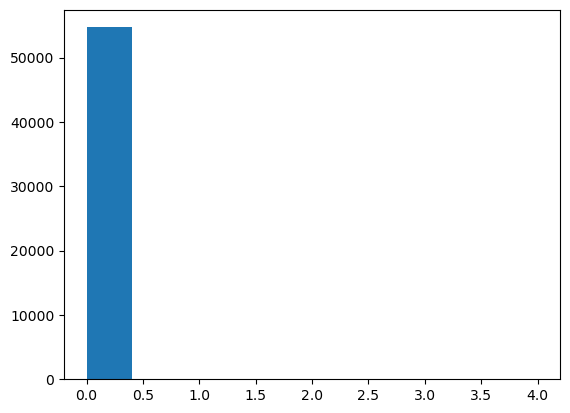

In [10]:
plt.hist(processed_train_csv["n_images"])

(array([8.2670e+03, 8.2210e+03, 2.7030e+03, 1.2760e+03, 9.0420e+03,
        2.4109e+04, 3.3800e+02, 7.3200e+02, 1.3000e+01, 5.0000e+00]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <BarContainer object of 10 artists>)

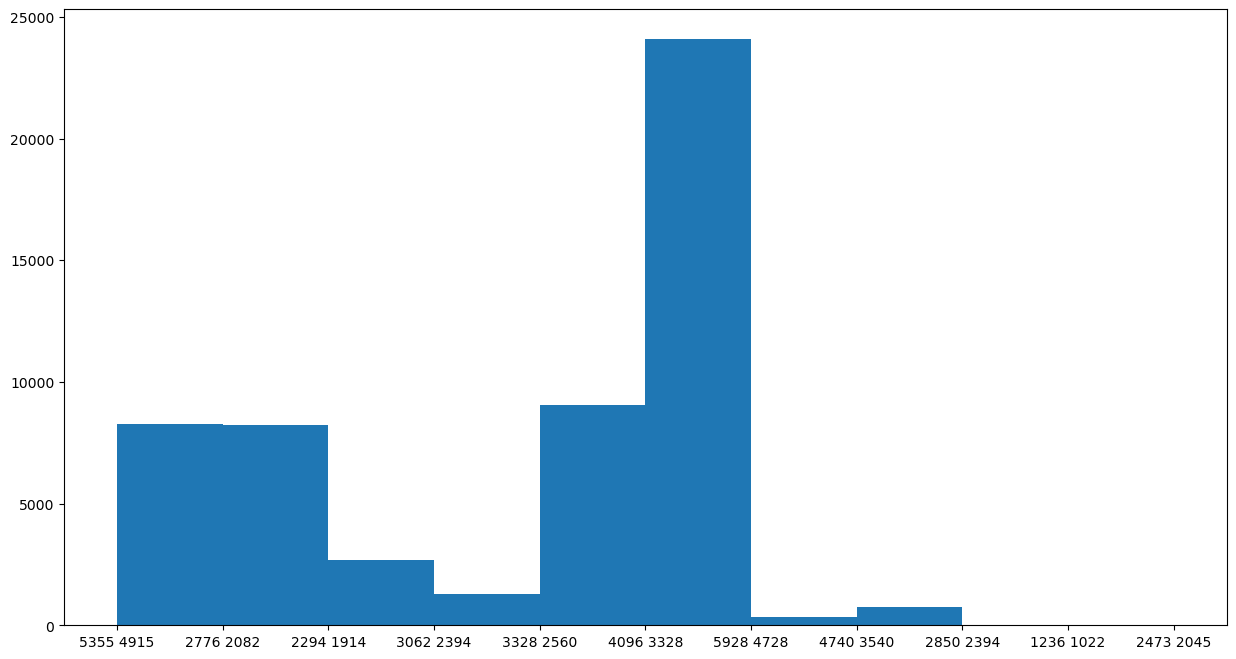

In [16]:
fig, axes = plt.subplots(1, 1, figsize=(15, 8))
axes.hist(processed_train_csv["resolution"])



In [18]:
import cv2

image = imageid_to_numpy(processed_train_csv['patient_id'][0], processed_train_csv['image_id'][0])
image.shape

/home/lepton/miniconda3/envs/breast_cancer/lib/python3.8/site-packages/openjpeg/utils.py:176: UserWarning: The (7FE0,0010) Pixel Data contains a JPEG 2000 codestream with the optional JP2 file format header, which is non-conformant to the DICOM Standard (Part 5, Annex A.4.4)
  warnings.warn(


(5355, 4915)

In [19]:
image1 = cv2.resize(image, (4096, 3328))

In [ ]:
processed_train_csv.head()